In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mpc

import pandas as pd

from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.utils import check_consistent_length, check_array, check_random_state
from sklearn.preprocessing import scale, normalize

import numpy as np
import h5py

from activ.viz import fitplot, multi_stemplot

from activ import load_data

In [3]:
data = load_data(uoinmf=False)
oc_orig = data.outcomes
bm_orig = data.biomarkers
oc = scale(oc_orig)
bm = scale(bm_orig)
gcs = bm_orig[:, 113]
gcs_simple = np.zeros(gcs.shape, dtype='<U8')

gcs_simple[gcs>0] = 'Severe'
gcs_simple[gcs>8] = 'Moderate'
gcs_simple[gcs>12] = 'Mild'
gose6M = oc_orig[:, 32]

In [4]:
output_path = "results/spcca.h5"
f = h5py.File(output_path, mode='r')
try:
    z = f['biomarker_embedding'][:]
    s = f['outcome_embedding'][:]
    beta = f['biomarker_effect'][:]
    theta = f['outcome_effect'][:]
except Exception as e:
    print("Could not open", output_path)
    print(e.args[0])
finally:
    f .close()

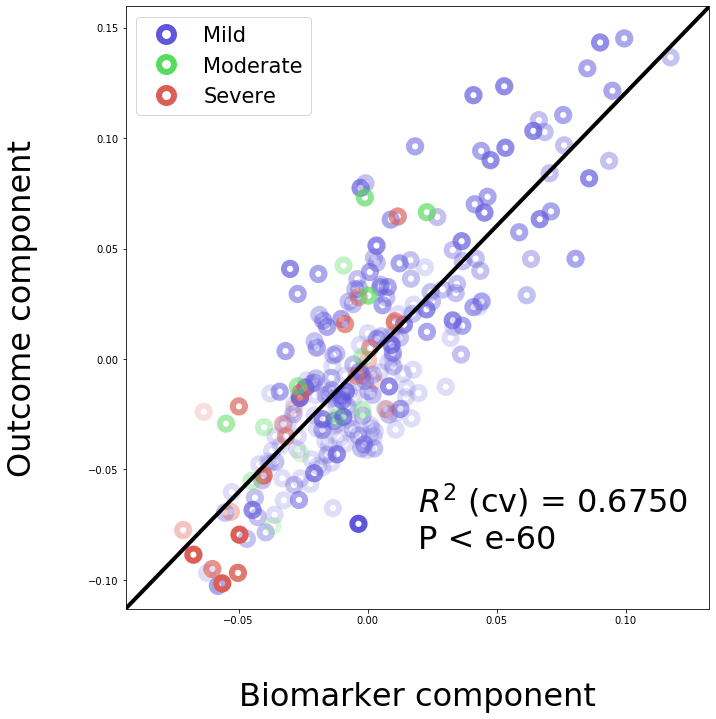

In [7]:
plt.figure(figsize=(10, 10))

fitplot(z, s, labels=gcs_simple, xlabel="Biomarker component", ylabel="Outcome component", fontsize=32, r2_display='cv', opacity=-gose6M)

plt.tight_layout()
plt.savefig("results/spcca_embeddings.opacityGOSE.png")

[<matplotlib.lines.Line2D object at 0x125826198>, <matplotlib.lines.Line2D object at 0x10efe6f28>, <matplotlib.lines.Line2D object at 0x10efe6668>, <matplotlib.lines.Line2D object at 0x10efe61d0>, <matplotlib.lines.Line2D object at 0x10efe65f8>, <matplotlib.lines.Line2D object at 0x10efe6b38>]


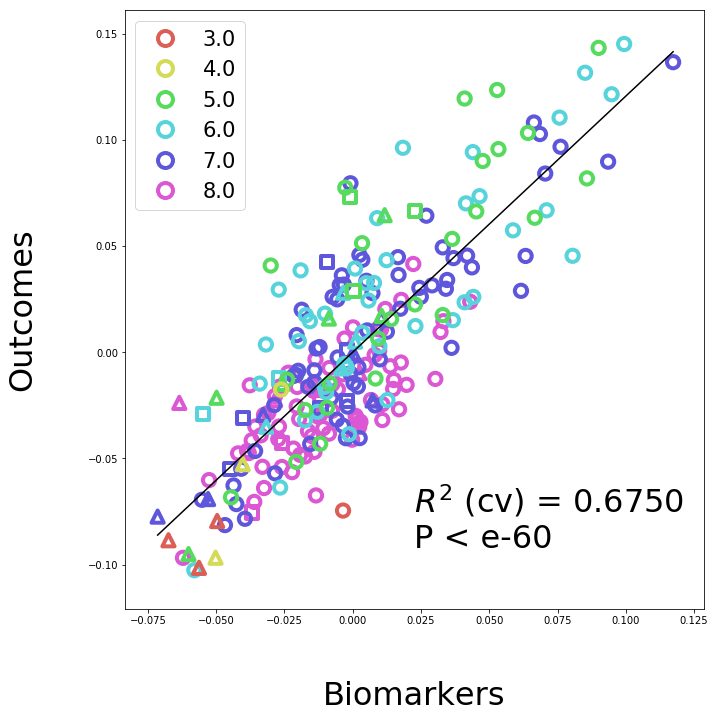

In [130]:
plt.figure(figsize=(10, 10))


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mpc
from scipy.stats import pearsonr

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression

def cv_r2_score(regressor, x, y, cv=5):
    x, y = _check_X_y(x, y)
    y_pred = cross_val_predict(regressor, x, y, cv=cv)
    cv_r, cv_p = pearsonr(y, y_pred)
    y_pred = regressor.fit(x,y).predict(x)
    raw_r, raw_p = pearsonr(y, y_pred)
    return raw_r**2, raw_p, cv_r**2, cv_p

def linefit(regressor, x, y):
    x, y = _check_X_y(x, y)
    regressor.fit(x, y)
    xfit = np.linspace(min(x),max(x), 1000).reshape((1000,1))
    yfit = regressor.predict(xfit)
    return xfit, yfit


def _check_X_y(x, y):
    x_ret = x
    y_ret = y
    if len(x.shape) == 1:
        x_ret = x.reshape(x.shape[0], 1)
    if len(y.shape) == 2:
        if y.shape[1] != 1:
            raise ValueError('y must be 1D: shape = %s' % str(y.shape))
        y_ret = y.reshape(y.shape[0])
    return x_ret, y_ret

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.colors as mpc


def get_labels(column, palette='hls', marker=None, solid_points=False):
    uniq = np.unique(column)
    colors = sns.color_palette(palette, len(uniq)).as_hex()
    lut = dict(zip(uniq, colors))
    labels = pd.Series([lut[v] for v in column])
    patches = [mpatches.Patch(color=c, label=l) for l, c in lut.items()]
    kwargs = dict(marker='o', color='none', markeredgewidth=4,
                          markerfacecolor='none', markersize=15)
    if solid_points:
        kwargs['markerfacecolor'] = None
    if marker is not None:
        kwargs['marker'] = marker
    patches = [mlines.Line2D([0], [0], label=l, markeredgecolor=c, **kwargs) for l,c in lut.items()]
    return labels, patches


def sort_by_count(ar):
    unique, count = np.unique(ar, return_counts=True)
    unique = unique[np.argsort(count)][::-1]
    return unique

def cross_decomp_scatter(x, y, regressor=LinearRegression(), labels=None, fitline=True,
                         solid_points=False, marker='o', opacity=None,
                         title=None, xlabel=None, ylabel=None, legend_title=None, ax=None,
                         r2_display='raw', fontsize=12):
    if ax is None:
        ax = plt.gca()
    _x, _y = _check_X_y(x, y)
    
    colors, patches = None, None
    if labels is not None:
        colors, patches = get_labels(labels, palette='hls')
    else:
        colors = ['black'] * _x.shape[0]
        
#     if opacity is not None:
#         opacity = np.array(opacity)
#         unique_opacity = np.sort(np.unique(opacity))
#         alphas = np.linspace(0.2, 1.0, unique_opacity.shape[0])
#         tmp = np.zeros(len(opacity))
#         for op, a in zip(unique_opacity, alphas):
#             tmp[opacity == op] = a
#         opacity = tmp
#     else:
#         opacity = np.array([1] * x.shape[0])
        
    colors = colors.values

    
    if solid_points:
        ax.scatter(p_x, p_y, c=p_c, s=5, marker=m)
    else:
        # sort by count, so we plot the densest one first
        for c in sort_by_count(colors):
            mask = colors == c
            p_x, p_y, p_c, p_o = _x[mask], _y[mask], colors[mask], opacity[mask]
            for o in sort_by_count(p_o):
                mask2 = p_o == o
                p_x2, p_y2, p_c2 = p_x[mask2], p_y[mask2], p_c[mask2]
                ax.scatter(p_x2, p_y2, edgecolors=p_c2, facecolors='none', s=150, linewidths=4, marker=o)
    
    if patches is not None:
        print(patches)
        ax.legend(handles=patches, title=legend_title, loc=2, prop={'size': int(fontsize*2/3)}, markerfirst=True)

    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontdict={'fontsize':fontsize})
        ax.xaxis.set_label_coords(0.5, -0.12)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontdict={'fontsize':fontsize})
        ax.yaxis.set_label_coords(-0.15, 0.5)

    
    if fitline:
        r2_raw, P_raw, r2_cv, P_cv = cv_r2_score(regressor, _x, _y)
        xfit, yfit = linefit(regressor, _x, _y)
        ax.plot(xfit, yfit, color='black')
        tmpl = "$R^2$ ({r2_display}) = %0.4f\nP < e%d"
        r2, P = None, None
        if r2_display == 'raw':
            r2, P = r2_raw, P_raw
        elif r2_display == 'cv':
            r2, P = r2_cv, P_cv
        if r2 is not None:
            tmpl = tmpl.format(r2_display=r2_display)
            power = int(np.ceil(np.log10(P_cv)))
            ax.text(0.5, 0.1, tmpl % (r2, power), size=fontsize, transform=ax.transAxes)
    return ax

ax = plt.gca()
#ax.set_facecolor('whitesmoke')

lut = {'Mild': 'o', 'Moderate': 's', 'Severe': '^'}
markers = np.array([lut[_] for _ in gcs_simple])

cross_decomp_scatter(z, s, labels=gose6M, xlabel="Biomarkers", ylabel="Outcomes", fontsize=32, r2_display='cv', opacity=markers)

plt.tight_layout()
plt.savefig("results/spcca_embeddings.shapeGOSE.png")

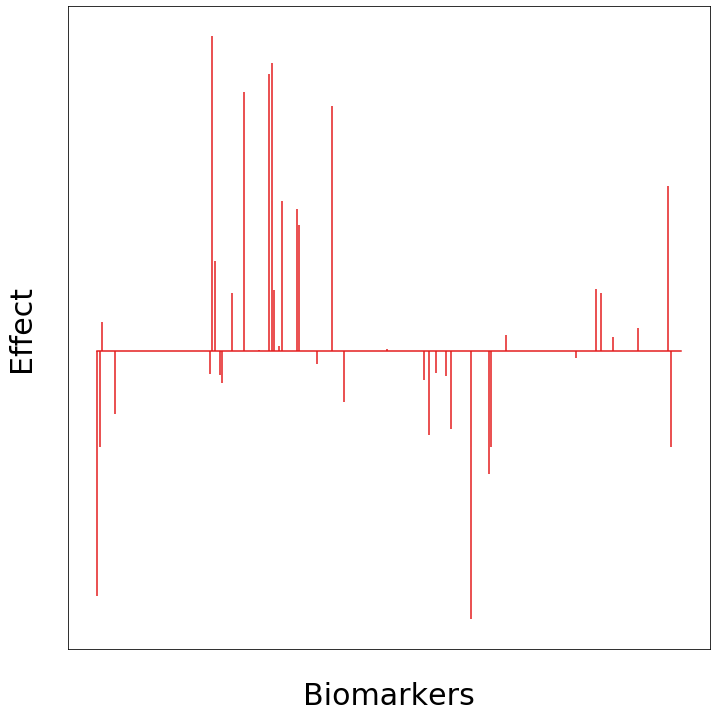

In [12]:
# def multi_stemplot(values, ax=None, labels=None, pal='Set1'):
#     if ax is None:
#         ax = plt.gca()
#     colors = [mpc.to_hex(c) for c in sns.color_palette(pal, values.shape[0])]
#     shift = np.max(np.abs(values))*2.1
#     for i in range(values.shape[0]):
#         ax.stem(values[i]+i*shift, markerfmt=' ', basefmt=colors[i], linefmt=colors[i], bottom=i*shift)
#     pos = np.arange(values.shape[0]) * shift
#     ax.get_xaxis().set_ticks([])
#     yaxis = ax.get_yaxis()
#     yaxis.set_ticks(pos)
#     ticklabels = np.arange(values.shape[0])
#     if labels is not None:
#         ticklabels = labels
#     yaxis.set_ticklabels(ticklabels)



plt.figure(figsize=(10,10))
ax = plt.gca()
multi_stemplot(beta.reshape((1, beta.shape[0])), ax=ax)
ax.set_xlabel("Biomarkers", fontdict={'fontsize':30})
ax.xaxis.set_label_coords(0.5, -0.05)

ax.set_ylabel("Effect", fontdict={'fontsize':30})
ax.yaxis.set_label_coords(-0.05, 0.5)
ax.set_yticks([])
for xlabel_i in ax.axes.get_yticklabels():
    xlabel_i.set_visible(False)
    

plt.tight_layout()
plt.savefig("results/spcca_biomarker_effects.png")

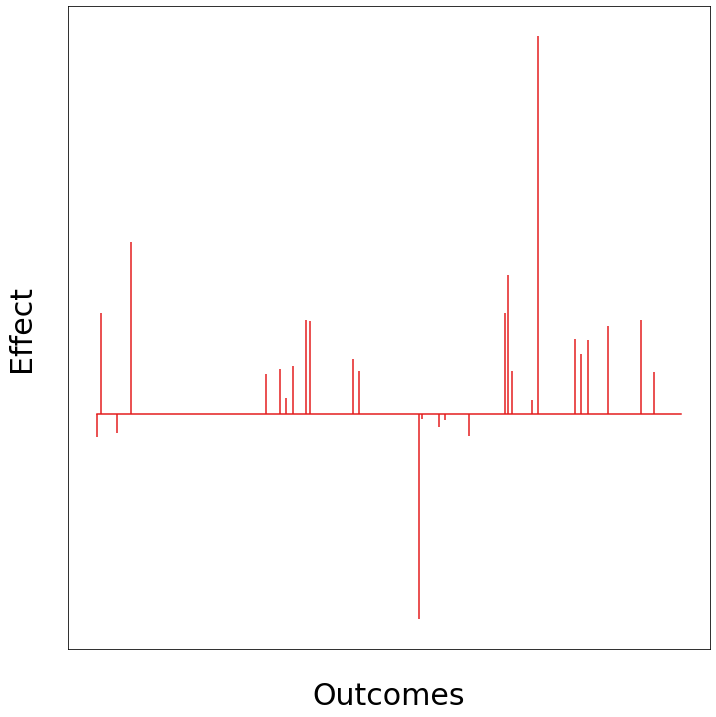

In [15]:
plt.figure(figsize=(10,10))
ax = plt.gca()
multi_stemplot(theta.reshape((1, theta.shape[0])), ax=ax)
ax.set_xlabel("Outcomes", fontdict={'fontsize':30})
ax.xaxis.set_label_coords(0.5, -0.05)

ax.set_ylabel("Effect", fontdict={'fontsize':30})
ax.yaxis.set_label_coords(-0.05, 0.5)
ax.set_yticks([])
for xlabel_i in ax.axes.get_yticklabels():
    xlabel_i.set_visible(False)
    
plt.tight_layout()
plt.savefig("results/spcca_outcome_effects.png")

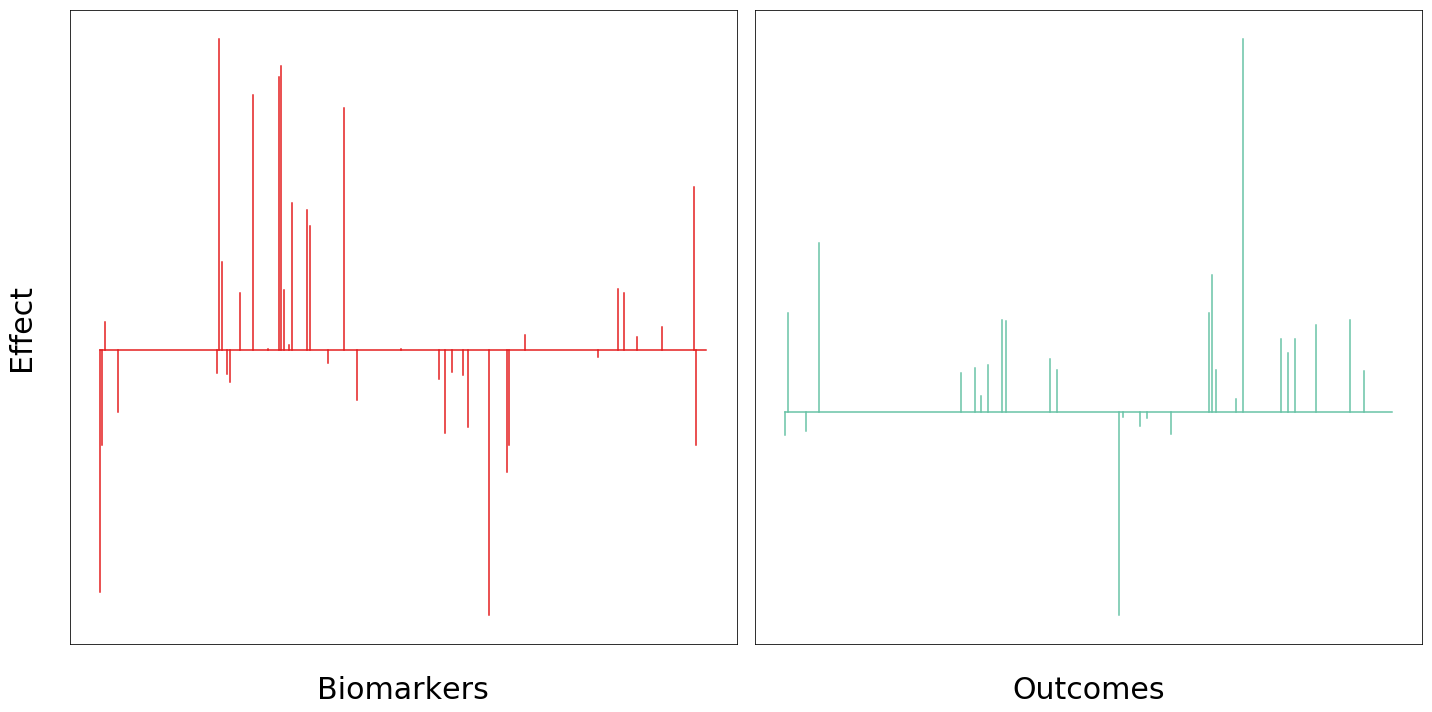

In [23]:
plt.figure(figsize=(20,10))

ax = plt.subplot(1,2,1)

multi_stemplot(sparse_cca.beta.reshape((1,sparse_cca.beta.shape[0])), ax=ax)
ax.set_xlabel("Biomarkers", fontdict={'fontsize':30})
ax.xaxis.set_label_coords(0.5, -0.05)

ax.set_ylabel("Effect", fontdict={'fontsize':30})
ax.yaxis.set_label_coords(-0.05, 0.5)
ax.set_yticks([])
for xlabel_i in ax.axes.get_yticklabels():
    xlabel_i.set_visible(False)
    

ax = plt.subplot(1,2,2)

multi_stemplot(sparse_cca.theta.reshape((1,sparse_cca.theta.shape[0])), ax=ax, pal='Set2')
ax.set_xlabel("Outcomes", fontdict={'fontsize':30})
ax.xaxis.set_label_coords(0.5, -0.05)

ax.yaxis.set_label_coords(-0.05, 0.5)
ax.set_yticks([])
for xlabel_i in ax.axes.get_yticklabels():
    xlabel_i.set_visible(False)
    
plt.tight_layout()
    
    
plt.tight_layout()
plt.savefig("results/spcca_effects.png")

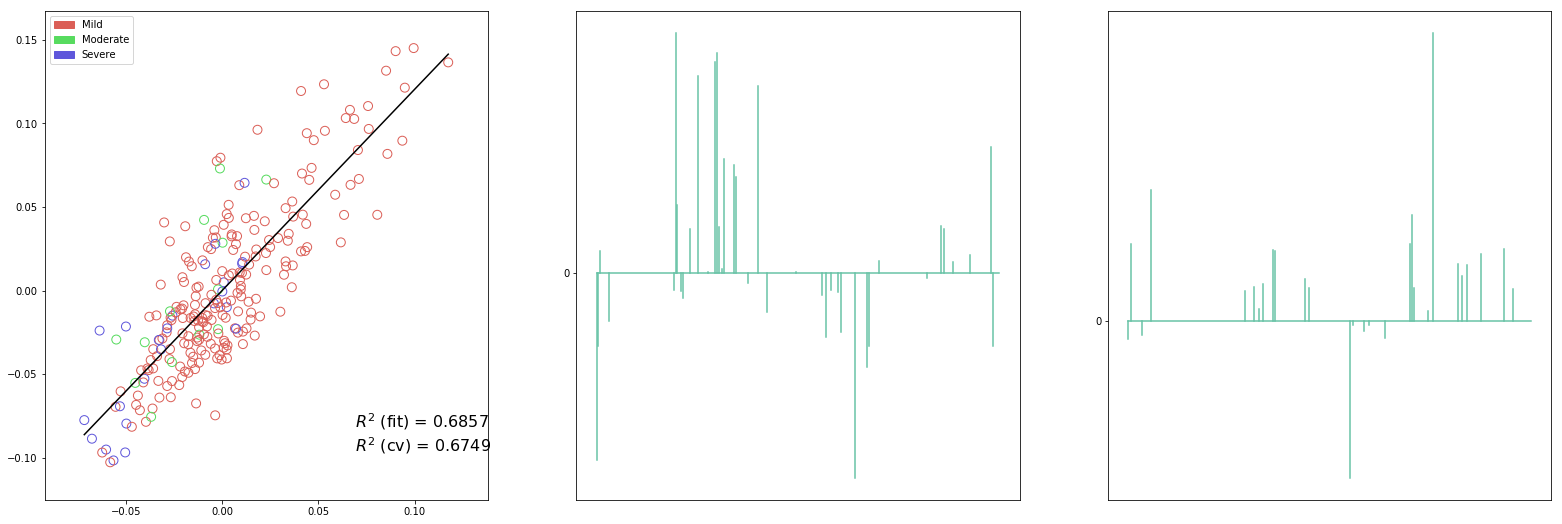

In [28]:
plt.figure(figsize=(27, 9))
plt.subplot(1, 3, 1)
cross_decomp_scatter(z, s, labels=gcs_simple)
plt.subplot(1, 3, 2)
multi_stemplot(sparse_cca.beta.reshape((1,sparse_cca.beta.shape[0])))
plt.subplot(1, 3, 3)
multi_stemplot(sparse_cca.theta.reshape((1,sparse_cca.theta.shape[0])))

In [30]:
idx = get_nnz(sparse_cca.beta)
print("%d nonzero features" % len(idx))
pd.DataFrame(data={'biomarker': data.biomarker_features[idx], 'coef': sparse_cca.beta[idx]})

21 nonzero features


,biomarker,coef
0,PMH_MSK_Other,0.008883
1,PMH_Psych_Depression,0.008122
2,PMH_Psych_Anxiety,0.007807
3,NeuromonitoringYesNo,-0.007563
4,PMH_Neuro_Headache,0.007290
5,cause_Assault,0.006915
6,Age,-0.006904
7,contusionmidbrainleft,0.004653
8,PMH_Psych_Other,0.004212
9,SHX_Alcohol,0.003995


In [31]:
idx = get_nnz(sparse_cca.theta)
print("%d nonzero features" % len(idx))
pd.DataFrame(data={'outcome': data.outcome_features[idx], 'coef': sparse_cca.theta[idx]})

22 nonzero features


,outcome,coef
0,PCLConcentrating_6mo,0.019762
1,CHARTSFOutHomeAssistTime_6mo,-0.010765
2,NeuroPhysLightSensitivity3mo,0.008975
3,PCLThinking_6mo,0.007253
4,PCLPhysicalReactions_6mo,0.005246
5,GOSE_WorkResume3M,0.005236
6,CVLTLongDelayCuedRecallRawScore_6mo,0.004894
7,RPQNausea_6mo,0.004882
8,RPQNoiseSensitivity_6mo,0.004817
9,CVLTTrial1To5RawScore_6mo,0.004596


In [33]:
bm_def = deflate(bm, z)
oc_def = deflate(oc, s)

In [34]:
beta_2, theta_2, z_2, s_2 = sparse_cca(bm_def, oc_def)

/Users/ajtritt/anaconda/envs/activ/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ajtritt/anaconda/envs/activ/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5527689637680737, tolerance: 0.3343134993669027
  positive)
/Users/ajtritt/anaconda/envs/activ/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ajtritt/anaconda/envs/activ/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: 

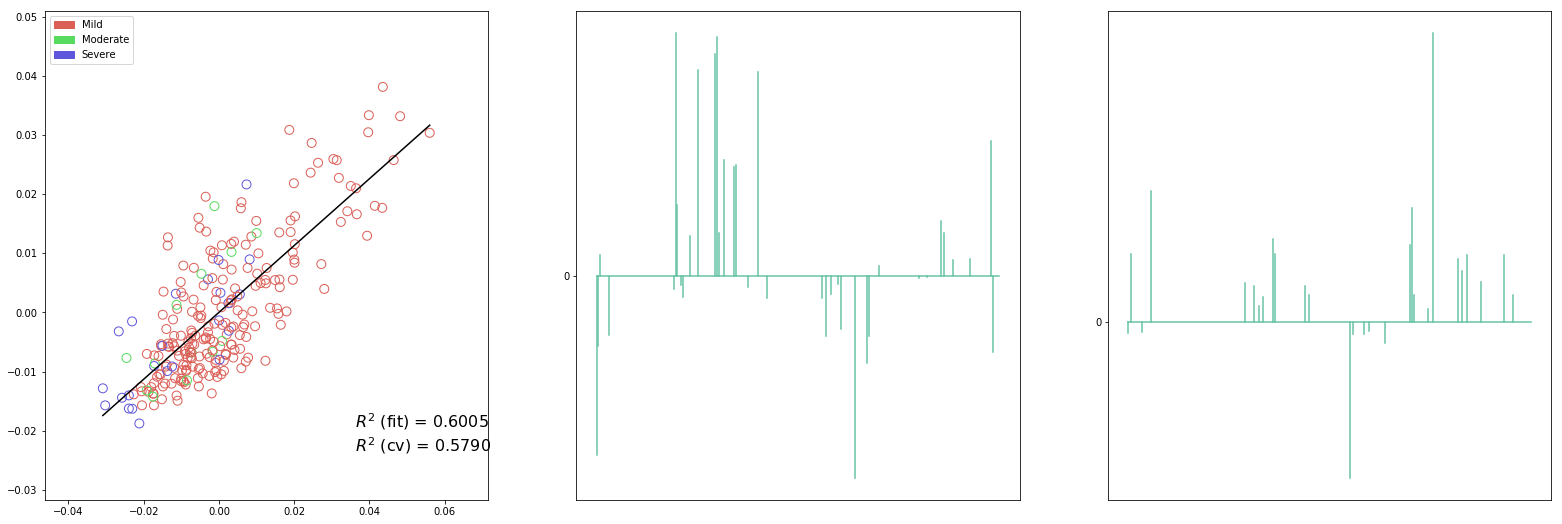

In [40]:
plt.figure(figsize=(27, 9))
plt.subplot(1, 3, 1)
cross_decomp_scatter(z_2, s_2, labels=gcs_simple)
plt.subplot(1, 3, 2)
multi_stemplot(beta_2.reshape((1,beta_2.shape[0])))
plt.subplot(1, 3, 3)
multi_stemplot(theta_2.reshape((1,theta_2.shape[0])))

In [41]:
idx = get_nnz(beta_2)
print("%d nonzero features" % len(idx))
pd.DataFrame(data={'biomarker': data.biomarker_features[idx], 'coef': beta_2[idx]})

18 nonzero features


,biomarker,coef
0,PMH_MSK_Other,0.008743
1,PMH_Psych_Depression,0.008596
2,PMH_Psych_Anxiety,0.007980
3,PMH_Neuro_Headache,0.007413
4,cause_Assault,0.007331
5,NeuromonitoringYesNo,-0.007257
6,Age,-0.006449
7,contusionmidbrainleft,0.004857
8,PMH_Psych_Other,0.004183
9,SHX_IllicitDrugs,0.003982


In [42]:
idx = get_nnz(theta_2)
print("%d nonzero features" % len(idx))
pd.DataFrame(data={'outcome': data.outcome_features[idx], 'coef': theta_2[idx]})

21 nonzero features


,outcome,coef
0,PCLConcentrating_6mo,0.020009
1,CHARTSFOutHomeAssistTime_6mo,-0.010801
2,NeuroPhysLightSensitivity3mo,0.009043
3,PCLThinking_6mo,0.007866
4,RPQNausea_6mo,0.005757
5,PCLPhysicalReactions_6mo,0.005339
6,GOSE_WorkResume3M,0.004699
7,RPQNoiseSensitivity_6mo,0.004695
8,CVLTLongDelayCuedRecallRawScore_6mo,0.004641
9,CVLTTrial3RawScore_6mo,0.004591


In [19]:
LA.norm(theta)

0.02887115787680759

In [82]:
bm.shape

(247, 235)